# COVID-19
> "Covid 19 graphs and stats"
- toc: true
- branch: master
- categories: [analysis, python]
- hide: false
- search_exclude: true
- show_tags: true

In [1]:
# hide
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
import datetime as dt
import math
from IPython.display import Markdown as md

sns.set_style('darkgrid')

In [2]:
# hide

# data source
url_confirmed = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
url_deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
# url_recovered = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'

df_c = pd.read_csv(url_confirmed)
df_d = pd.read_csv(url_deaths)
# df_r = pd.read_csv(url_recovered)

In [3]:
# hide

countries = sorted(['Italy','US','Germany','Spain', 'UK', 'Poland', 'Israel', 'World'])

countries_without_world = sorted(['Italy','US','Germany','Spain', 'UK', 'Poland', 'Israel'])

def start(df):
    return df.copy()

def add_world(df):
    world = df.sum(axis=0)
    df.loc[len(df)] = world
    df.loc[len(df)-1,'Country/Region'] = 'World'
    return df

def clean(df):
    df = df.rename(columns={'Country/Region':'country', 'Province/State':'state'})
    # keep uk as uk
    to_drop = df[(df['country']=='United Kingdom') & (~df['state'].isna())].index
    df = df.drop(index=to_drop)
    df.loc[df['country']=='United Kingdom','country'] = 'UK'
    return df


def clean_rec(df):
    df = df.rename(columns={'Country/Region':'country', 'Province/State':'state'})
    # keep uk as uk
    to_drop = df[(df['country']=='United Kingdom') & (df['state'] != 'United Kingdom')].index
    df = df.drop(index=to_drop)
    df.loc[df['country']=='United Kingdom','country'] = 'UK'
    return df

def group_and_stack(df):
    date_columns = list(set(df.columns) - set(['country', 'state','Lat','Long']))
    df_stack = (df.groupby(['country'])[date_columns].sum().stack()
                    .reset_index().rename(columns={'level_1':'date',0:'count'})).copy()
    df_stack['count'] = df_stack['count'].astype(int)
    return df_stack

def convert_date(df):
    df['date'] = pd.to_datetime(df['date'],format='%m/%d/%y')
    return df.sort_values(by=['country','date'])

def add_daily_change(df):
    df['daily_change']=df.groupby(['country'])['count'].diff()
    df['daily_percent_change'] = df['daily_change']/df['count'].shift(1)*100
    df.loc[df[df['daily_percent_change']==np.inf].index,'daily_percent_change']=0
    df = df.fillna(0)
    return df

def limit_countries(df):
    df = df[df['country'].isin(countries)]
    return df

def add_days_from_100_confirmed(df):
    df['days'] = 1
    df['days'] = df.groupby('country')['days'].cumsum()-1
    
    for country in countries:
        more_than_100 = df[(df['count']>=100) & (df['country']==country)]
        if len(more_than_100) > 0:
            dd = more_than_100.iloc[[0]]['days'].values[0]
            df.loc[df[df['country']==country].index, 'days_from_100']=\
                df.loc[df[df['country']==country].index, 'days'] - dd
        else:
            df['days_from_100'] = 0
    return df

def add_days_from_10_dead(df):
    df['days'] = 1
    df['days'] = df.groupby(['country'])['days'].cumsum()-1
    df['days_from_10'] = 0
    for country in countries:
        more_than_10 = df[(df['count']>=8) & (df['country']==country)]
        if len(more_than_10) > 0:
            dd = more_than_10.iloc[[0]]['days'].values[0]
            df.loc[df[df['country']==country].index, 'days_from_10']=\
                df.loc[df[df['country']==country].index, 'days'] - dd
    return df

In [4]:
# hide

df_confirmed = (df_c.pipe(start)
                    .pipe(add_world)                
                    .pipe(clean)
                    .pipe(group_and_stack)
                    .pipe(convert_date)
                    .pipe(add_daily_change)
                    .pipe(limit_countries)
                    .pipe(add_days_from_100_confirmed))

# df_recovered = (df_r.pipe(start)
#                     .pipe(add_world)                
#                     .pipe(clean_rec)
#                     .pipe(group_and_stack)
#                     .pipe(convert_date)
#                     .pipe(add_daily_change)
#                     .pipe(limit_countries))

df_death = (df_d.pipe(start)
                    .pipe(add_world)                
                    .pipe(clean)
                    .pipe(group_and_stack)
                    .pipe(convert_date)
                    .pipe(add_daily_change)
                    .pipe(limit_countries)
                    .pipe(add_days_from_10_dead))

In [5]:
# hide_input
date = df_confirmed['date'].max().date()
weekday_map = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
day_of_week = weekday_map[date.weekday()]

md(f"""Last Updated: {day_of_week}, {date} <br>
   Data Source: 2019 Novel Coronavirus COVID-19 (2019-nCoV) 
   [Data Repository](https://github.com/CSSEGISandData/COVID-19) by Johns Hopkins CSSE """)

Last Updated: Tuesday, 2020-03-24 <br>
   Data Source: 2019 Novel Coronavirus COVID-19 (2019-nCoV) 
   [Data Repository](https://github.com/CSSEGISandData/COVID-19) by Johns Hopkins CSSE 

## Cases by country

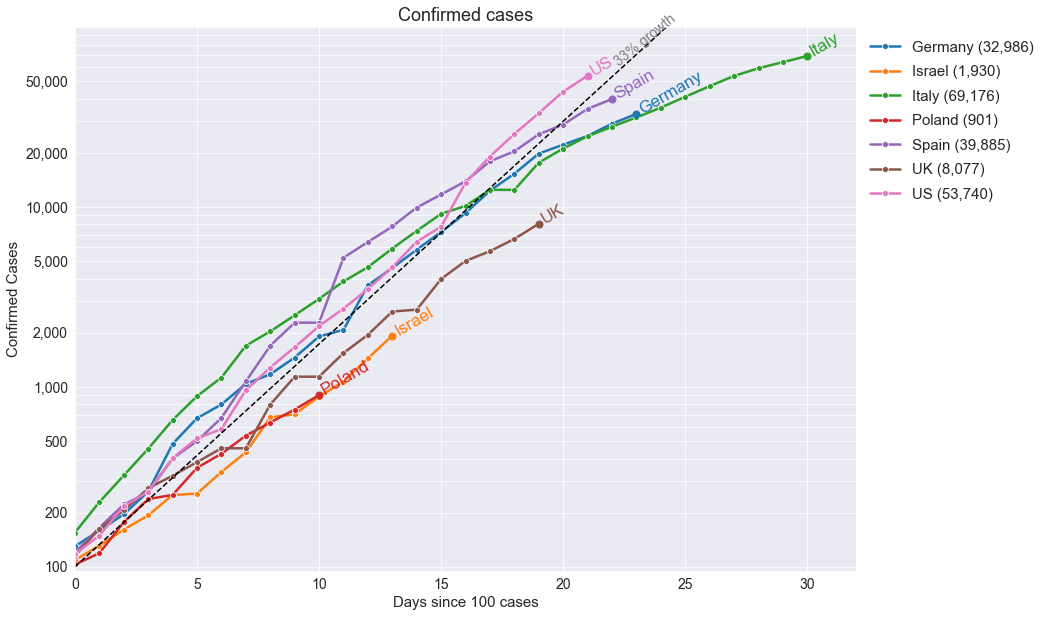

In [6]:
# hide_input

df_no_world = df_confirmed[df_confirmed['country'].isin(countries_without_world)].copy()

days = (dt.datetime.now().date()
        - df_no_world[df_no_world['days_from_100']>0]['date'].dt.date.min()).days+2

x = np.arange(0,days)
def exp_growth(x, days_to_double=None):
    return 100*(1.33)**x

max_count = df_no_world['count'].max()

fig,ax=plt.subplots(figsize=(14,10))

sns.lineplot(data=df_no_world,
             x='days_from_100', 
             y='count', 
             hue='country', marker='o', linewidth=2.5)

ax.plot(x, exp_growth(x,3), linestyle='--',color='k')

ax.set_yscale('log')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.tick_params(axis='both', labelsize=14);
ax.set_ylabel('Confirmed Cases', fontsize=15);
ax.set_xlabel('Days since 100 cases', fontsize=15)

labels = [f"""{country} ({format(df_no_world[df_no_world['country']==country].
          iloc[-1]['count'],',')})""" for country in countries_without_world]

for id, row in df_no_world.groupby(['country']).last().reset_index().iterrows():
    plt.annotate(s=row['country'], 
                 xy=(row['days_from_100'], row['count']),
                 fontsize=17, rotation=30, color=sns.color_palette()[id])

    plt.plot(row['days_from_100'], row['count'], marker='o', markersize=7,
             color=sns.color_palette()[id])
    
ax.annotate(s='33% growth', xy=(days-10,1.15*exp_growth(days-10)), fontsize=14, color='gray',
            rotation=39)

ax.yaxis.grid(True, which='minor')

base = np.array([10,20,50])
ticks=[]
for i in range(int(np.log10(max_count))):
    ticks.extend(base*10**i)

ax.set_yticks(ticks)
ax.set(xlim=(0,days), ylim=(95, 10**(round(np.log10(max_count)))))

plt.legend(title='', loc='upper left', labels=labels, bbox_to_anchor=(1, 1), frameon=False,
           fontsize=15, scatterpoints=None,labelspacing=0.7);
plt.title("Confirmed cases",fontsize=18);

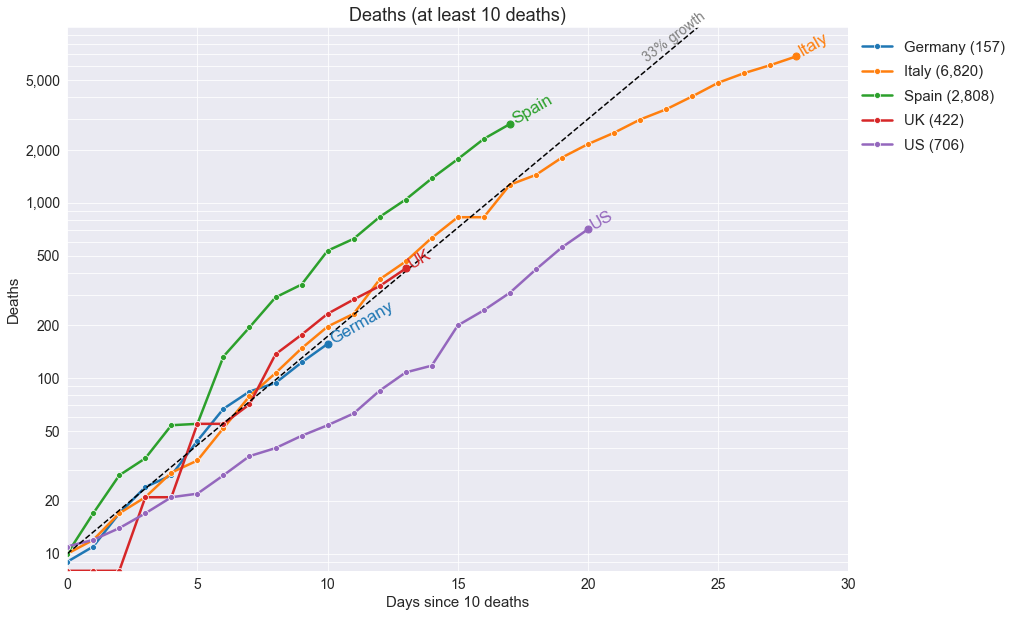

In [7]:
# hide_input

deaths_country = df_death.groupby(['country'])['count'].max().reset_index()
countries_at_least_10 = deaths_country[deaths_country['count']>10].country.values

countries_at_least_10 = [c for c in countries_at_least_10 if c != 'World']

df_no_world = df_death[(df_death['country'].isin(countries_at_least_10))].copy()

days = (dt.datetime.now().date()
        - df_no_world[df_no_world['days_from_10']>0]['date'].dt.date.min()).days+2

x = np.arange(0,days)
def exp_growth(x, days_to_double=None):
    """
    exponential growth with doubling after days_to_double
    """
    return 10*(1.33)**x

max_count = df_no_world['count'].max()

fig,ax=plt.subplots(figsize=(14,10))

sns.lineplot(data=df_no_world,
             x='days_from_10', 
             y='count', 
             hue='country', marker='o', linewidth=2.5)

ax.plot(x, exp_growth(x), linestyle='--',color='k')

ax.set_yscale('log')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.set(xlim=(0,days), ylim=(8, 10**(round(np.log10(max_count)))))
ax.tick_params(axis='both', labelsize=14);
ax.set_ylabel('Deaths', fontsize=15);
ax.set_xlabel('Days since 10 deaths', fontsize=15)

labels = [f"""{country} ({format(df_no_world[df_no_world['country']==country].
          iloc[-1]['count'],',')})""" for country in countries_at_least_10]

for id, row in df_no_world.groupby(['country']).last().reset_index().iterrows():
    plt.annotate(s=row['country'], 
                 xy=(row['days_from_10'], row['count']),
                 fontsize=17, rotation=30, color=sns.color_palette()[id])

    plt.plot(row['days_from_10'], row['count'], marker='o', markersize=7,
             color=sns.color_palette()[id])
        
ax.annotate(s='33% growth', xy=(days-8,1.2*exp_growth(days-8)),
            fontsize=14, color='gray',rotation=37)

ax.yaxis.grid(True, which='minor')

base = np.array([10,20,50])
ticks=[]
for i in range(int(np.log10(max_count))):
    ticks.extend(base*10**i)

ax.set_yticks(ticks)

plt.legend(title='', loc='upper left', labels=labels, bbox_to_anchor=(1, 1), frameon=False,
           fontsize=15, scatterpoints=None,labelspacing=0.7);
plt.title("Deaths (at least 10 deaths)",fontsize=18);

## Worldwide Cases

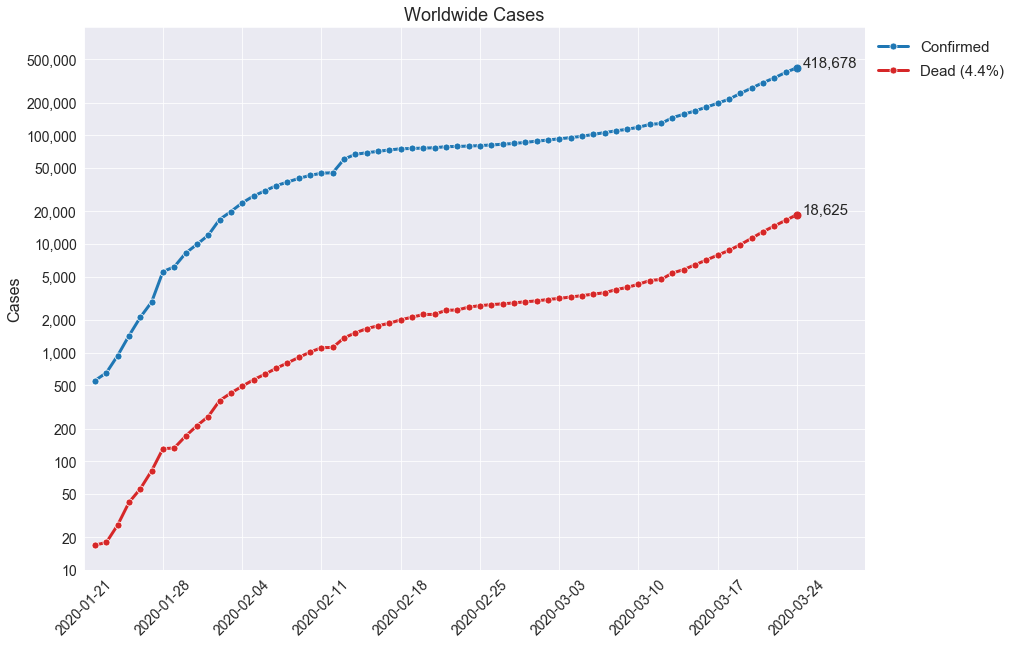

In [8]:
# hide_input

# Worldwide growth

confirmed = df_confirmed[df_confirmed['country']=="World"].iloc[-1]['count']
# recovered = df_recovered[df_recovered['country']=="World"].iloc[-1]['count']
dead = df_death[df_death['country']=="World"].iloc[-1]['count']
# unresolved = int(confirmed - (dead+recovered))

last_day = df_confirmed[df_confirmed['country']=="World"].iloc[-1]['date']
first_day = df_confirmed[df_confirmed['country']=="World"].iloc[0]['date']

max_count = df_confirmed[df_confirmed['country']=="World"]['count'].max()

fig,ax=plt.subplots(figsize=(14,10))

sns.lineplot(data=df_confirmed[df_confirmed['country'] == "World"],
             x='date', y='count', marker='o',  ax=ax, color=sns.color_palette()[0],
            linewidth=3, markersize=7)

# sns.lineplot(data=df_recovered[df_recovered['country'] == "World"],
#              x='date', y='count', marker='o', ax=ax, color=sns.color_palette()[2],
#             linewidth=3, markersize=7)

sns.lineplot(data=df_death[df_death['country'] == "World"],
             x='date', y='count', marker='o', ax=ax, color=sns.color_palette()[3],
             linewidth=3, markersize=7)

# left = df_recovered[df_recovered['country'] == "World"].copy()
# left['count'] = df_confirmed[df_confirmed['country']=='World']['count'].astype(int)  - \
#                     (df_death[df_death['country'] == "World"]['count'].astype(int) + \
#                     df_recovered[df_recovered['country']=="World"]['count'].astype(int))


# left = df_confirmed[df_confirmed['country'] == "World"].copy().reset_index(drop=True)
# left['count'] = left['count'] - (df_death[df_death['country'] == "World"]['count'].reset_index(drop=True) + \
#                                  df_recovered[df_recovered['country']=="World"]['count'].reset_index(drop=True))

# sns.lineplot(data=left,
#              x='date', y='count', marker='o', ax=ax, color=sns.color_palette()[4],
#              linewidth=3, markersize=7)

plt.plot(df_confirmed[df_confirmed['country'] == "World"]['date'].iloc[-1], 
         df_confirmed[df_confirmed['country'] == "World"]['count'].iloc[-1],
         marker='o', markersize=7,
         color=sns.color_palette()[0])

# plt.plot(df_recovered[df_recovered['country'] == "World"]['date'].iloc[-1], 
#          df_recovered[df_recovered['country'] == "World"]['count'].iloc[-1],
#          marker='o', markersize=7,
#          color=sns.color_palette()[2])

plt.plot(df_death[df_death['country'] == "World"]['date'].iloc[-1], 
         df_death[df_death['country'] == "World"]['count'].iloc[-1],
         marker='o', markersize=7,
         color=sns.color_palette()[3])

# plt.plot(left['date'].iloc[-1], 
#          left['count'].iloc[-1],
#          marker='o', markersize=7,
#          color=sns.color_palette()[3])

ax.set_yscale('log')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: 
                                                                   format(int(x), ',')))

ax.tick_params(axis='both', labelsize=14);
ax.tick_params(axis='x', rotation=45);
ax.set_ylabel('Cases', fontsize=16);
ax.set_xlabel('')

ax.set_ylim(10, 10**math.ceil(np.log10(max_count)))
ax.set_xlim(first_day - dt.timedelta(days=1), last_day + dt.timedelta(days=6))

ax.annotate(s=format(confirmed,","), xy=(last_day + dt.timedelta(days=0.5), confirmed), fontsize=15)

# ax.annotate(s=format(recovered,","), xy=(last_day + dt.timedelta(days=0.5), recovered), fontsize=15)

ax.annotate(s=format(dead,","), xy=(last_day + dt.timedelta(days=0.5), dead), fontsize=15)

# ax.annotate(s=format(unresolved,","), xy=(last_day + dt.timedelta(days=0.5), unresolved), fontsize=15)

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

base = np.array([10,20,50])
ticks=[]
for i in range(int(np.log10(max_count))):
    ticks.extend(base*10**i)

ax.set_yticks(ticks)

labels = ["Confirmed",
#           f"Recovered ({recovered/confirmed*100:.1f}%)",
          f"Dead ({dead/confirmed*100:.1f}%)",]
#           f"Unresolved ({unresolved/confirmed*100:.1f}%)"]
plt.legend(title='', loc='upper left', labels=labels, bbox_to_anchor=(1, 1), frameon=False,
           fontsize=15, scatterpoints=None,labelspacing=0.7);

plt.title("Worldwide Cases",fontsize=18);


## Daily Spread Rate

Percentage change in confirmed cases relative to total confirmed cases in previous day

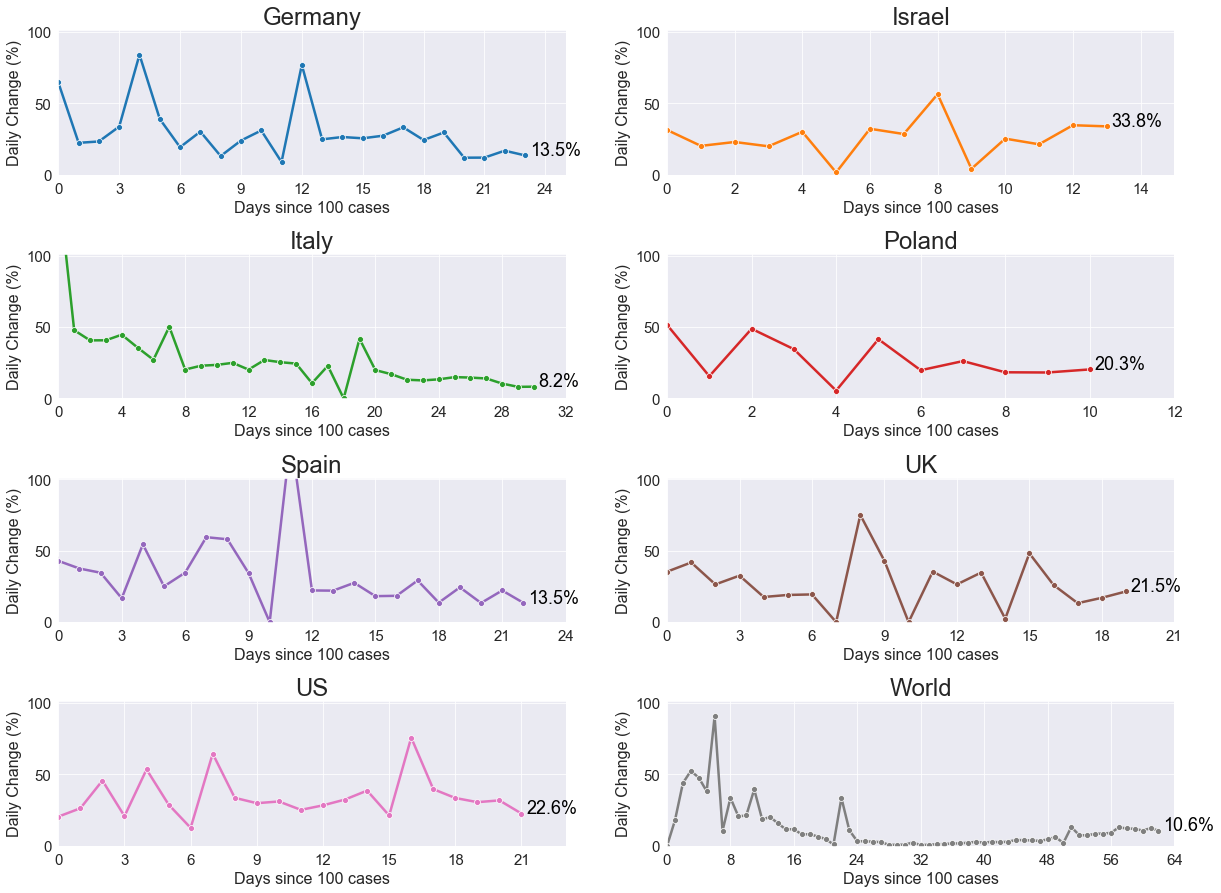

In [9]:
# hide_input

fig,ax=plt.subplots(4,2, figsize=(20,15))

i=0
j=-1
k=-1
for country in countries:
    k+=1
    j=j+1
    if j==2:
        j = 0
        i += 1
    df_cnt = df_confirmed[df_confirmed['country']==country]
    days = (dt.datetime.now().date()-
        df_cnt[df_cnt['days_from_100']>0]['date'].dt.date.min()).days

    sns.lineplot(data=df_cnt,
                 x='days_from_100', 
                 y='daily_percent_change', marker='o', linewidth=2.5,
                 ax=ax[i][j],
                color=sns.color_palette()[k])
    ax[i][j].set_xlim(0,days+2)
    ax[i][j].set_ylim(0,101)
    ax[i][j].set_xlabel('Days since 100 cases', fontsize=16)
    ax[i][j].xaxis.set_major_locator(MaxNLocator(integer=True))
    ax[i][j].set_ylabel('Daily Change (%)', fontsize=16)
    ax[i][j].tick_params(axis='both', labelsize=15)
    ax[i][j].set_title(country, fontsize=24)
    last_change = df_cnt.iloc[-1]['daily_percent_change']
    ax[i][j].annotate(s=f"{last_change:.1f}%", xy=(days*1.01,last_change), fontsize=18,color='k')
plt.subplots_adjust(hspace=0.55, wspace=0.2)

## Daily Death Rate

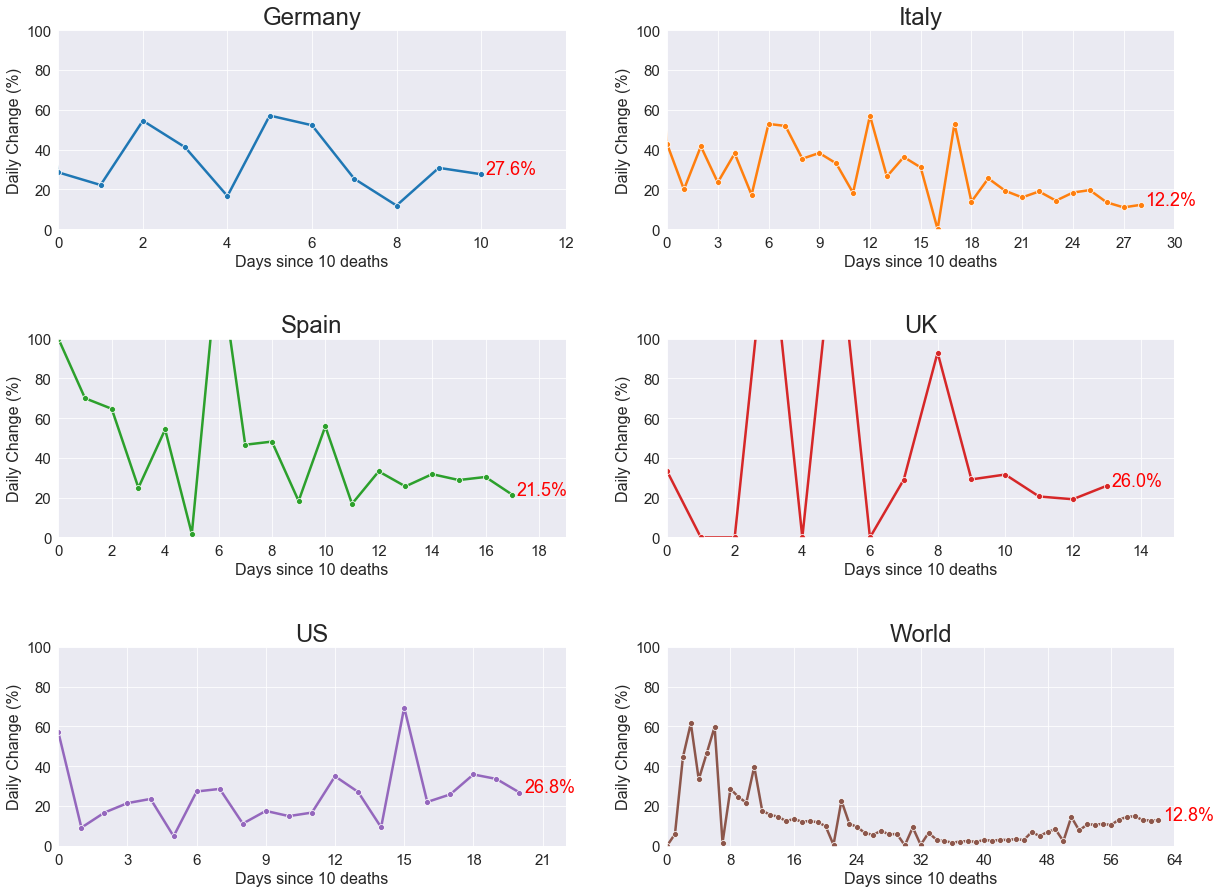

In [10]:
# hide_input


# countries with at least 10 deaths
deaths_10_num = sum(df_death.groupby(['country']).last()['count']>=10)


fig,ax=plt.subplots(int(deaths_10_num/2), 2, figsize=(20,15))

i=0
j=-1
k=-1
for country in countries:
    df_cnt = df_death[df_death['country']==country]    
    if (df_cnt['count'].iloc[-1]>10):
        k+=1
        j=j+1
        if j==2:
            j = 0
            i += 1
        days = (dt.datetime.now().date()-df_cnt[df_cnt['days_from_10']>0]['date'].dt.date.min()).days

        sns.lineplot(data=df_cnt,
                     x='days_from_10', 
                     y='daily_percent_change', marker='o', linewidth=2.5,
                     ax=ax[i][j],
                    color=sns.color_palette()[k])
        ax[i][j].set_xlim(0,days+2)
        ax[i][j].set_ylim(0,100)
        ax[i][j].set_xlabel('Days since 10 deaths', fontsize=16)
        ax[i][j].xaxis.set_major_locator(MaxNLocator(integer=True))
        ax[i][j].set_ylabel('Daily Change (%)', fontsize=16)
        ax[i][j].tick_params(axis='both', labelsize=15)
        ax[i][j].set_title(country, fontsize=24)
        last_change = df_cnt.iloc[-1]['daily_percent_change']
        ax[i][j].annotate(s=f"{last_change:.1f}%", xy=(days*1.01,last_change), fontsize=18,color='r')

plt.subplots_adjust(hspace=0.55, wspace=0.2)

<!-- ## Mortality Rate (Using resolved cases) -->

In [11]:
# hide


# # countries with at least 10 deaths
# deaths_10_num = sum(df_death.groupby(['country']).last()['count']>=10)


# fig,ax=plt.subplots(int(deaths_10_num/2), 2, figsize=(20,15))

# i=0
# j=-1
# k=-1
# for country in countries:
#     df_cnt = df_death[df_death['country']==country].reset_index(drop=True)
#     df_rec = df_recovered[df_recovered['country']==country].copy().reset_index(drop=True)    
#     if (df_cnt['count'].iloc[-1]>10):
#         k+=1
#         j=j+1
#         if j==2:
#             j = 0
#             i += 1
#         days = (dt.datetime.now().date()-df_cnt[df_cnt['days_from_10']>0]['date'].dt.date.min()).days

#         df_cnt['mortality'] = 100*(df_cnt['count']/(df_rec['count']+df_cnt['count']))
#         sns.lineplot(data=df_cnt,
#                      x='days_from_10', 
#                      y='mortality', marker='o', linewidth=2.5,
#                      ax=ax[i][j],
#                     color=sns.color_palette()[k])
#         ax[i][j].set_xlim(0,days+2)
#         ax[i][j].set_ylim(0,101)
#         ax[i][j].set_xlabel('Days since 10 deaths', fontsize=16)
#         ax[i][j].xaxis.set_major_locator(MaxNLocator(integer=True))
#         ax[i][j].set_ylabel('Mortality Rate (%)', fontsize=16)
#         ax[i][j].tick_params(axis='both', labelsize=15)
#         ax[i][j].set_title(country, fontsize=24)
#         last_change = df_cnt.iloc[-1]['mortality']
#         ax[i][j].annotate(s=f"{last_change:.1f}%", xy=(days, 1.01*last_change), fontsize=18,color='r')

# plt.subplots_adjust(hspace=0.55, wspace=0.2)

In [12]:
# hide_input
md(f"## Summary table - {day_of_week}, {date}")

## Summary table - Tuesday, 2020-03-24

In [13]:
# hide_input

df_summary = (df_confirmed.groupby(['country'],as_index=False)['count']\
 .last().rename(columns={'count':'Confirmed'})\
 .merge(df_death.groupby(['country'],as_index=False)['count']\
        .last().rename(columns={'count':'Deaths'}), on='country')\
 .merge(df_confirmed.groupby(['country'],as_index=False)['daily_change'].last()\
        .rename(columns={'daily_change':'Daily confirmed'}), on='country')\
 .merge(df_death.groupby(['country'],as_index=False)['daily_change'].last()\
        .rename(columns={'daily_change':'Daily deaths'}), on='country')\
 .merge(df_confirmed.groupby(['country'],as_index=False)['daily_percent_change'].last()\
        .rename(columns={'daily_percent_change':'Daily increase (confirmed)'}), on='country')  
 .merge(df_death.groupby(['country'],as_index=False)['daily_percent_change'].last()\
        .rename(columns={'daily_percent_change':'Daily increase (deaths)'}), on='country') 
 .sort_values(by='Confirmed',ascending=False)).rename(columns={'country':'Country'})\
 .set_index('Country')

df_summary['Daily confirmed'] = df_summary['Daily confirmed'].astype(int).apply(lambda x: f"{x:,}")
df_summary['Daily deaths'] = df_summary['Daily deaths'].astype(int).apply(lambda x: f"{x:,}")
df_summary['Deaths'] = df_summary['Deaths'].astype(int).apply(lambda x: f"{x:,}")
df_summary['Confirmed'] = df_summary['Confirmed'].astype(int).apply(lambda x: f"{x:,}")
df_summary['Daily increase (confirmed)'] = df_summary['Daily increase (confirmed)']\
                                                    .apply(lambda x: f"{x:.1f}%")
df_summary['Daily increase (deaths)'] = df_summary['Daily increase (deaths)']\
                                                    .apply(lambda x: f"{x:.1f}%")

df_summary['Daily confirmed'] = df_summary.apply(lambda x: f"{x['Daily confirmed']} (+{x['Daily increase (confirmed)']})", axis=1)
df_summary['Daily deaths'] = df_summary.apply(lambda x: f"{x['Daily deaths']} (+{x['Daily increase (deaths)']})", axis=1)

df_summary[['Confirmed','Deaths','Daily confirmed','Daily deaths']]

,Confirmed,Deaths,Daily confirmed,Daily deaths
Country,,,,
World,"418,678","18,625","40,131 (+10.6%)","2,120 (+12.8%)"
Italy,"69,176","6,820","5,249 (+8.2%)",743 (+12.2%)
US,"53,740",706,"9,893 (+22.6%)",149 (+26.8%)
Spain,"39,885","2,808","4,749 (+13.5%)",497 (+21.5%)
Germany,"32,986",157,"3,930 (+13.5%)",34 (+27.6%)
UK,"8,077",422,"1,427 (+21.5%)",87 (+26.0%)
Israel,"1,930",3,488 (+33.8%),2 (+200.0%)
Poland,901,10,152 (+20.3%),2 (+25.0%)
